In [1]:
# Importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sqlalchemy import create_engine
from password import password

In [2]:
protocol = 'postgresql'
username = 'postgres'
password = password
host = 'localhost'
port = 5432
database_name = 'churn_pred'
rds_connection_string = f'{protocol}://{username}:{password}@{host}:{port}/{database_name}'
engine = create_engine(rds_connection_string)
connection = engine.connect()

In [3]:
# Loading and displaying a dataset
df = pd.read_sql("SELECT * FROM fact_churn", connection)
df.head()

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,churn,international_plan_yes,voice_mail_plan_yes
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,1,0,1
1,118,0,223.4,98,37.98,220.6,101,18.75,203.9,118,9.18,6.3,6,1.70,0,0,1,0
2,62,0,120.7,70,20.52,307.2,76,26.11,203.0,99,9.14,13.1,6,3.54,4,0,0,0
3,93,0,190.7,114,32.42,218.2,111,18.55,129.6,121,5.83,8.1,3,2.19,3,1,0,0
4,174,0,124.3,76,21.13,277.1,112,23.55,250.7,115,11.28,15.5,5,4.19,3,1,0,0


In [219]:
# Split the data into X_train, X_test, y_train, y_test
X = df.drop(['churn'], axis=1)
y = df['churn'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size = 0.35)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [220]:
# Checking data split in training
X_train.shape

(3250, 17)

In [221]:
# Checking data split in testing
X_test.shape

(1750, 17)

In [222]:
# Retrieving sample of the data
X.sample(5)

,account_length,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,international_plan_yes,voice_mail_plan_yes
634,122,0,184.6,88,31.38,148.8,98,12.65,309.7,58,13.94,14.3,2,3.86,3,0,0
4919,181,16,196.0,85,33.32,107.1,119,9.10,205.9,110,9.27,9.7,1,2.62,1,0,1
2986,63,33,184.2,111,31.31,312.6,89,26.57,264.0,55,11.88,12.2,4,3.29,1,0,1
3268,201,0,212.7,72,36.16,225.2,90,19.14,195.1,99,8.78,7.0,6,1.89,1,0,0
3384,31,28,171.8,116,29.21,240.7,125,20.46,245.5,80,11.05,10.6,7,2.86,1,0,1


In [223]:
# Tuning Hyper-parameter
rfc = RandomForestClassifier(criterion='entropy',
                             max_depth=10, random_state=42,
                             class_weight='balanced_subsample',
                             n_estimators = 150,
                             min_samples_split = 10)

In [228]:
# Testing the optimised model
rfc.fit(X_train_scaled, y_train)
thresh = 0.33
pt = np.where(rfc.predict_proba(X_test_scaled)[:,1] > thresh, 1, 0)
print(f"Training Data Score: {rfc.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {rfc.score(X_test_scaled, y_test)}")

Training Data Score: 0.94
Testing Data Score: 0.8948571428571429


In [229]:
# Creating a confusion matrix without threshold change
y_pred = rfc.predict(X_test_scaled)
confusion_matrix = metrics.confusion_matrix(y_test, y_pred)
confusion_matrix

array([[1385,   45],
       [ 139,  181]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

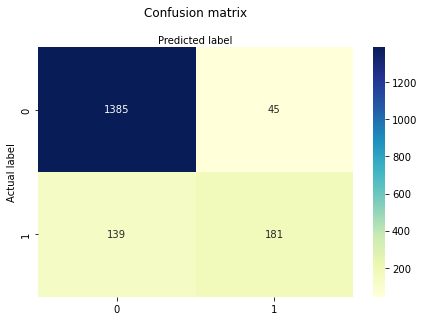

In [230]:
# Creating confusion matrix diagram
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create a heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [231]:
# Creating a confusion matrix on new threshold
confusion_matrix = metrics.confusion_matrix(y_test, pt)
confusion_matrix

array([[1260,  170],
       [ 112,  208]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

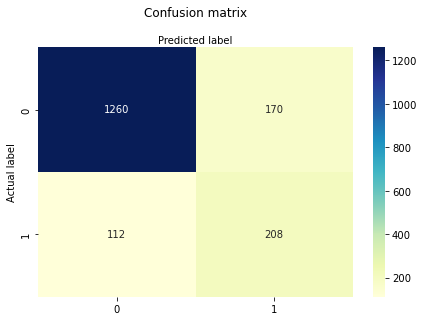

In [232]:
# Creating confusion matrix diagram
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create a heatmap
sns.heatmap(pd.DataFrame(confusion_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [233]:
# Create the classification report
target_names = ['churn: no', 'churn: yes']
print(classification_report(y_test, pt, target_names=target_names))

              precision    recall  f1-score   support

   churn: no       0.92      0.88      0.90      1430
  churn: yes       0.55      0.65      0.60       320

    accuracy                           0.84      1750
   macro avg       0.73      0.77      0.75      1750
weighted avg       0.85      0.84      0.84      1750



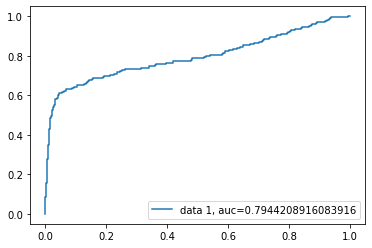

In [234]:
# Create area under the curve graph
y_pred_proba = rfc.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr,label='data 1, auc=' + str(auc))
plt.legend(loc=4)
plt.show()